# Forest Cover Type Prediction - Complete Project

## Objective
This notebook combines detailed Exploratory Data Analysis (EDA) with advanced model benchmarking.
1. **Exploratory Data Analysis (EDA):** Visualize distributions, wilderness areas, soil types, and correlations.
2. **Feature Engineering:** Create new features based on distance and elevation interactions.
3. **Model Benchmarking:** Train and evaluate 7 different algorithms (LR, SVM, KNN, DT, RF, ET, XGB).
4. **Performance Comparison:** Compare metrics and select the best model.
5. **Deployment:** Save the optimal model and create a prediction system.

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 2. Data Loading & Variable Setup

In [17]:
print("Loading Data...")
df = pd.read_csv('train.csv')

# Drop Id if present
if 'Id' in df.columns:
    df = df.drop(['Id'], axis=1)

# Define variable groups for plotting (Required for EDA)
categorical_variables = ["Cover_Type"] + [f"Wilderness_Area{i}" for i in range(1,5)] + [f"Soil_Type{i}" for i in range(1,41)]
continuous_variables = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
                        "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
                        "Horizontal_Distance_To_Fire_Points", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]
continuous_variables_labels = ["Elevation", "Aspect", "Slope", "Horizontal Dist. To Hydrology", 
                               "Vertical Dist. To Hydrology", "Horizontal Dist. To Roadways", 
                               "Horizontal Dist. To Fire Points", "Hillshade 9am", "Hillshade Noon", "Hillshade 3pm"]

print(f'Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.')
df.info(verbose=True, show_counts=True)

Loading Data...
Loaded dataset with 15120 rows and 55 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           15120 non-null  int64
 1   Aspect                              15120 non-null  int64
 2   Slope                               15120 non-null  int64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 4   Vertical_Distance_To_Hydrology      15120 non-null  int64
 5   Horizontal_Distance_To_Roadways     15120 non-null  int64
 6   Hillshade_9am                       15120 non-null  int64
 7   Hillshade_Noon                      15120 non-null  int64
 8   Hillshade_3pm                       15120 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 10  Wilderness_Area1                    15120 non-null  int64
 11  Wild

In [18]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# 3. Exploratory Data Analysis (EDA)
Visualizing the data to understand relationships before modeling.

### 3.1 Cover types by Wilderness Area

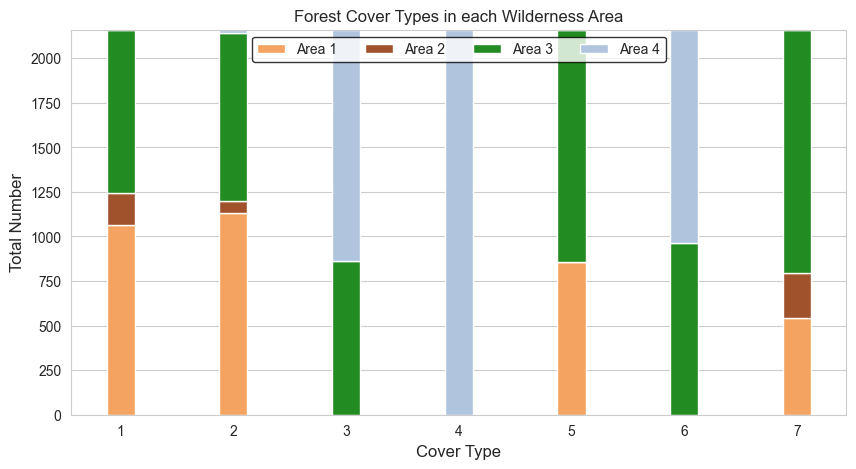

In [3]:
area_1_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area1"])
area_2_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area2"])
area_3_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area3"])
area_4_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area4"])

plt.figure(figsize=(10, 5))
p1 = plt.bar(range(1,8), area_1_counts, width=0.25, color='sandybrown', label="Area 1")
p2 = plt.bar(range(1,8), area_2_counts, width=0.25, bottom=area_1_counts, color='sienna', label="Area 2")
p3 = plt.bar(range(1,8), area_3_counts, width=0.25, bottom=area_1_counts+area_2_counts, color='forestgreen', label="Area 3")
p4 = plt.bar(range(1,8), area_4_counts, width=0.25, bottom=area_1_counts+area_2_counts+area_3_counts, color='lightsteelblue', label="Area 4")

plt.legend(ncol=4, loc="upper center", frameon=True, edgecolor='k')
plt.xlabel("Cover Type", fontsize=12)
plt.ylabel("Total Number", fontsize=12)
plt.title("Forest Cover Types in each Wilderness Area", fontsize=12)
plt.show()

### 3.2 Distributions of continuous variables per Cover Type

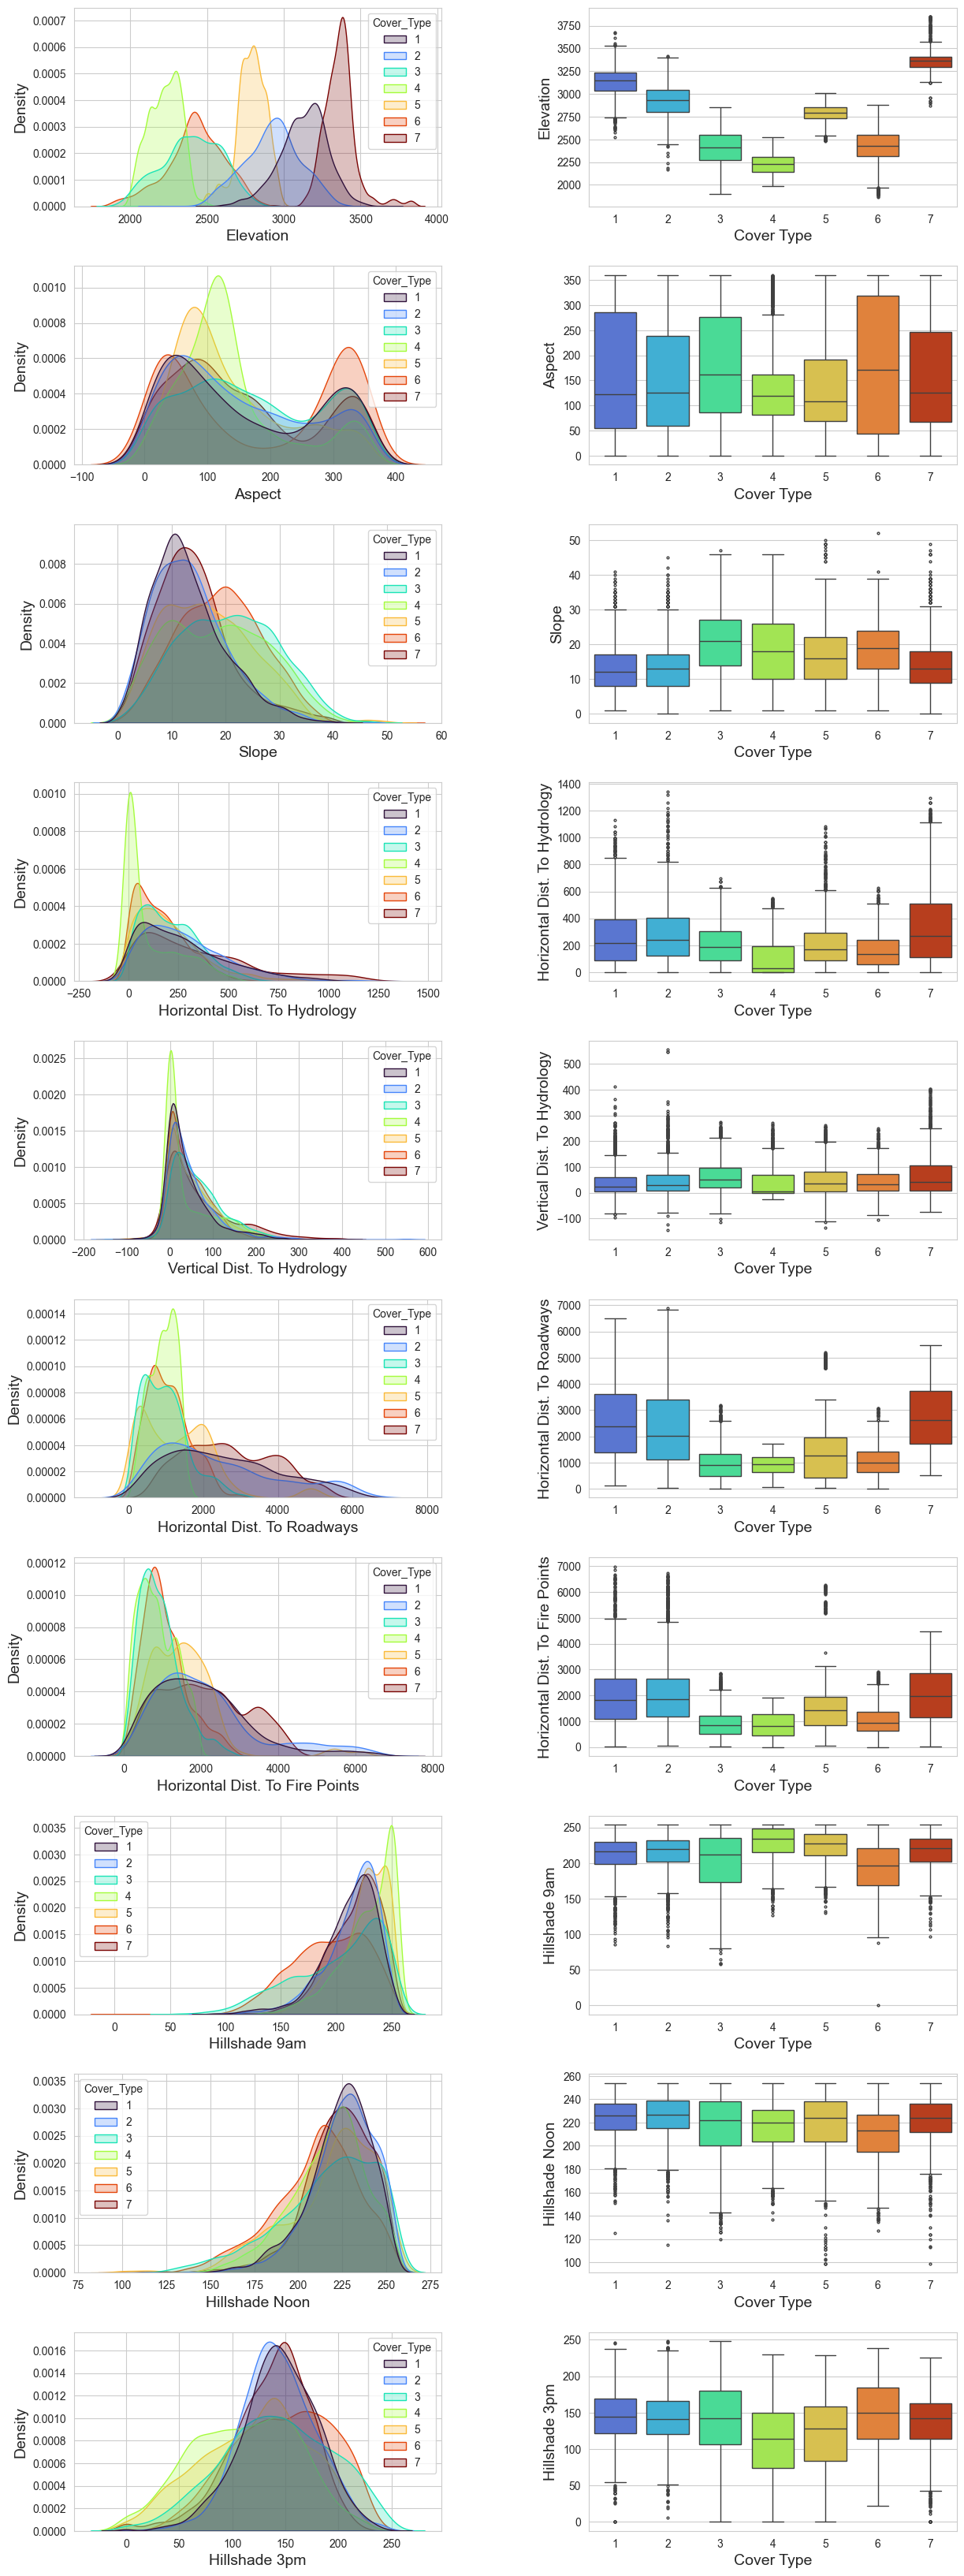

In [4]:
fig, axs = plt.subplots(10, 2, figsize=(14,40))

for i in range(len(continuous_variables)):
    sns.kdeplot(data=df, x=continuous_variables[i], hue='Cover_Type', palette='turbo', fill=True, ax=axs[i][0])
    sns.boxplot(data=df, y=continuous_variables[i], x='Cover_Type', palette='turbo', fliersize=2, ax=axs[i][1])
    
    axs[i][0].set_xlabel(continuous_variables_labels[i], fontsize=14)
    axs[i][1].set_ylabel(continuous_variables_labels[i], fontsize=14)
    axs[i][1].set_xlabel('Cover Type', fontsize=14)
    axs[i][0].set_ylabel('Density', fontsize=14)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)
plt.show()

### 3.3 Soil Type Frequency

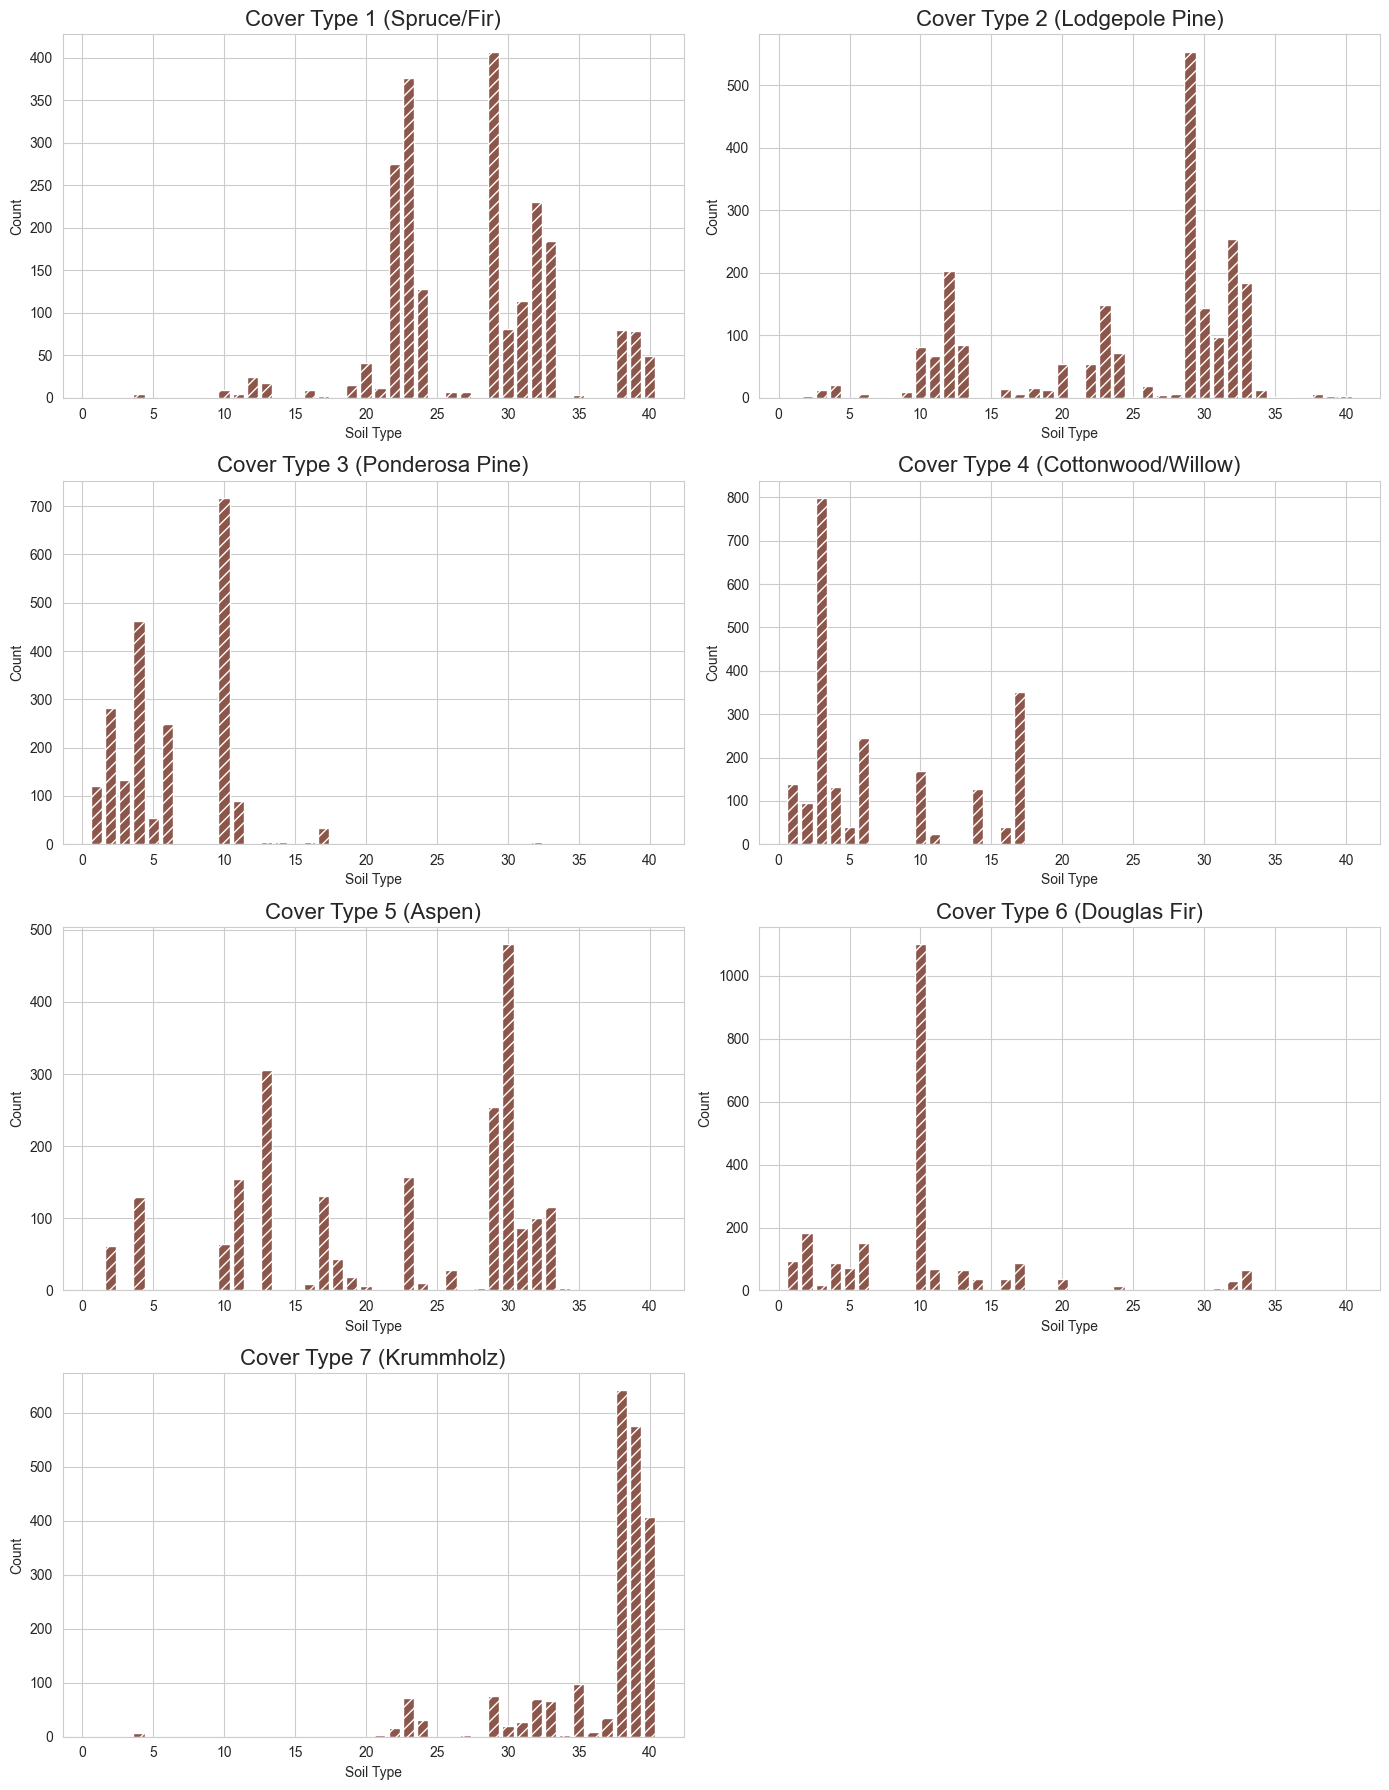

In [5]:
cover_df = df.groupby('Cover_Type').sum()

soil_data = []
for i in range(1, 8): # Cover types 1-7
    soil_counts = np.array([cover_df['Soil_Type'+str(j)][i] for j in range(1,41)])
    soil_data.append(soil_counts)

fig, axs = plt.subplots(4, 2, figsize=(14, 18))
titles = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas Fir', 'Krummholz']

ax_flat = axs.flatten()

for i in range(7):
    ax_flat[i].bar(x=list(range(1,41)), height=soil_data[i], hatch='///', color='tab:brown')
    ax_flat[i].set_title(f'Cover Type {i+1} ({titles[i]})', fontsize=16)
    ax_flat[i].set_xlabel('Soil Type')
    ax_flat[i].set_ylabel('Count')

ax_flat[7].axis('off') # Hide 8th plot

plt.tight_layout()
plt.show()

### 3.4 Correlation Heatmap

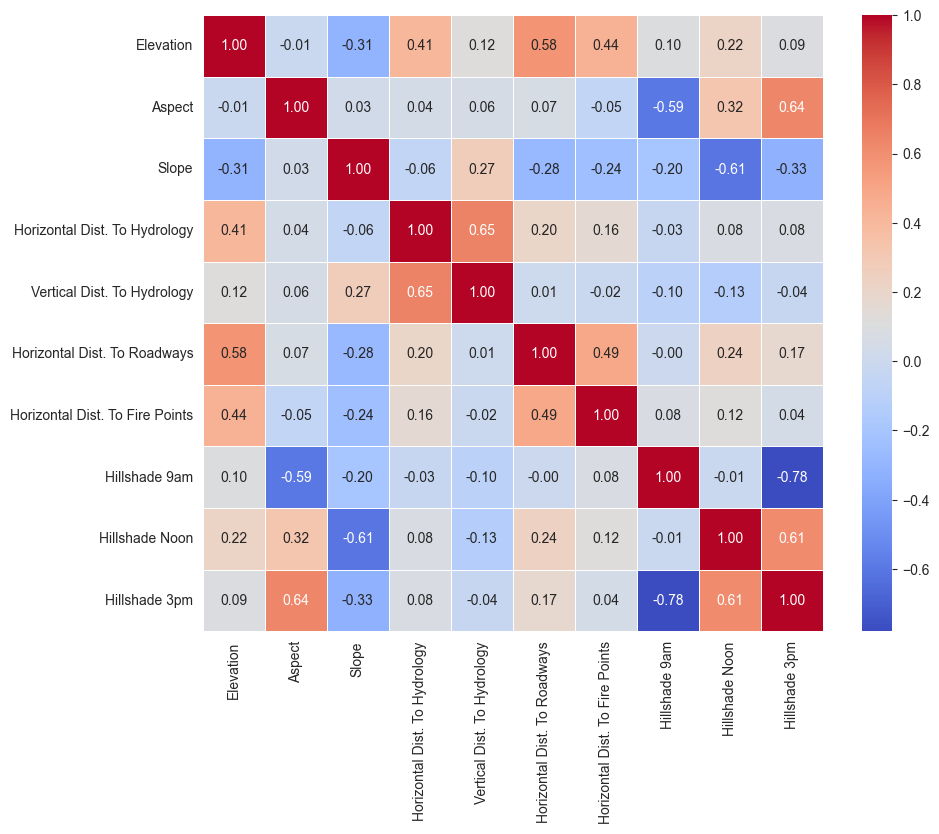

In [6]:
plt.figure(figsize=(10,8))
corr = df[continuous_variables].corr()
sns.heatmap(corr, xticklabels=continuous_variables_labels, yticklabels=continuous_variables_labels, 
            linewidths=0.5, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

### 3.5 Jointplots of Interesting Features

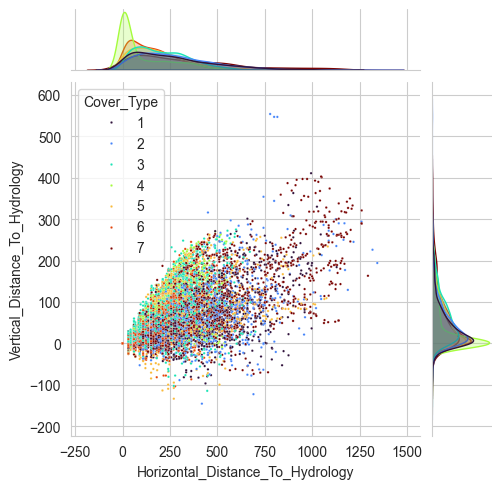

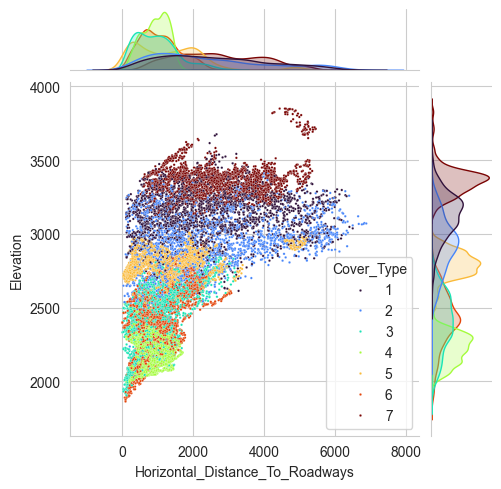

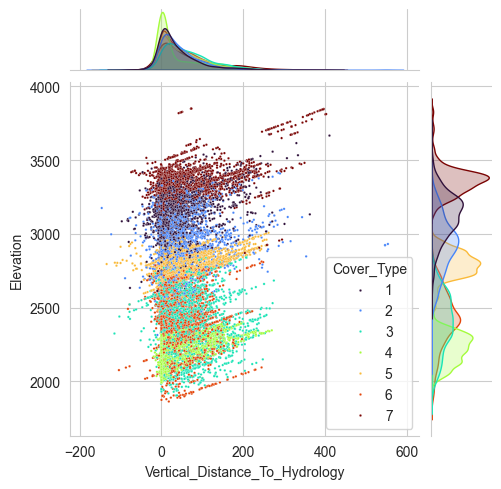

In [7]:
# Vert Dist vs Horiz Dist
sns.jointplot(data=df, x="Horizontal_Distance_To_Hydrology", y="Vertical_Distance_To_Hydrology", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

# Elevation vs Roadways
sns.jointplot(data=df, x="Horizontal_Distance_To_Roadways", y="Elevation", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

# Elevation vs Vertical Hydrology
sns.jointplot(data=df, x="Vertical_Distance_To_Hydrology", y="Elevation", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

# 4. Feature Engineering
Creating linear combinations of features to help the model separate classes.

In [8]:
df['Total_Distance_To_Hydrology'] = (df['Vertical_Distance_To_Hydrology']**2 + df['Horizontal_Distance_To_Hydrology']**2)**0.5
df['Elevation_Plus_Vertical_Hydrology'] = df['Elevation'] + df['Vertical_Distance_To_Hydrology']
df['Elevation_Minus_Vertical_Hydrology'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']
df['Hydrology_Plus_Fire_Points'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
df['Hydrology_Minus_Fire_Points'] = df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points']
df['Hydrology_Plus_Roadways'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways']
df['Hydrology_Minus_Roadways'] = df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways']
df['Fire_Points_Plus_Roadways'] = df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways']
df['Fire_Points_Minus_Roadways'] = df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways']

print("Feature Engineering Complete.")

Feature Engineering Complete.


## 5. Data Splitting & Scaling

In [9]:
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']
y_mapped = y - 1  # 0-6 mapping for compatibility

X_train, X_valid, y_train, y_valid = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

# Identifying continuous columns
continuous_cols = [c for c in X.columns if not c.startswith('Wilderness') and not c.startswith('Soil')]

# Scaling
scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_valid[continuous_cols] = scaler.transform(X_valid[continuous_cols])

joblib.dump(scaler, 'best_scaler.pkl')
print("Data Scaled and Scaler Saved.")

Data Scaled and Scaler Saved.


## 6. Model Benchmarking
We will train each model individually and store their metrics.

In [10]:
# Dictionary to store results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

def evaluate_model(name, model, X_tr, y_tr, X_val, y_val):
    print(f"--- Training {name} ---")
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    
    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, average='weighted')
    rec = recall_score(y_val, preds, average='weighted')
    f1 = f1_score(y_val, preds, average='weighted')
    
    results['Model'].append(name)
    results['Accuracy'].append(acc)
    results['Precision'].append(prec)
    results['Recall'].append(rec)
    results['F1-Score'].append(f1)
    
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_val, preds))
    return model

### 6.1 Train All Models

In [11]:
# Logistic Regression
lr_model = evaluate_model("Logistic Regression", 
                          LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42), 
                          X_train, y_train, X_valid, y_valid)

# SVM
svm_model = evaluate_model("SVM", SVC(random_state=42), X_train, y_train, X_valid, y_valid)

# KNN
knn_model = evaluate_model("KNN", KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_valid, y_valid)

# Decision Tree
dt_model = evaluate_model("Decision Tree", DecisionTreeClassifier(random_state=42), X_train, y_train, X_valid, y_valid)

# Random Forest
rf_model = evaluate_model("Random Forest", RandomForestClassifier(n_estimators=200, random_state=42), X_train, y_train, X_valid, y_valid)

# ExtraTrees
et_model = evaluate_model("ExtraTrees", ExtraTreesClassifier(n_estimators=200, random_state=42), X_train, y_train, X_valid, y_valid)

# XGBoost
xgb_model = evaluate_model("XGBoost", 
                           XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss'), 
                           X_train, y_train, X_valid, y_valid)

--- Training Logistic Regression ---
Accuracy: 0.7106
              precision    recall  f1-score   support

           0       0.67      0.70      0.68       421
           1       0.64      0.53      0.58       438
           2       0.63      0.53      0.58       428
           3       0.78      0.88      0.83       449
           4       0.70      0.79      0.74       416
           5       0.62      0.64      0.63       432
           6       0.90      0.91      0.90       440

    accuracy                           0.71      3024
   macro avg       0.71      0.71      0.71      3024
weighted avg       0.71      0.71      0.71      3024

--- Training SVM ---
Accuracy: 0.8019
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       421
           1       0.75      0.64      0.69       438
           2       0.73      0.71      0.72       428
           3       0.84      0.96      0.90       449
           4       0.85      0.90      0

## 7. Comparative Analysis
Let's visualize which model performed the best across all metrics.

                 Model  Accuracy  Precision    Recall  F1-Score
5           ExtraTrees  0.902447   0.900842  0.902447  0.901168
4        Random Forest  0.895833   0.894020  0.895833  0.894125
6              XGBoost  0.878968   0.876800  0.878968  0.877020
2                  KNN  0.821429   0.816734  0.821429  0.817128
3        Decision Tree  0.809193   0.807355  0.809193  0.808033
1                  SVM  0.801918   0.798634  0.801918  0.798760
0  Logistic Regression  0.710648   0.706435  0.710648  0.706073


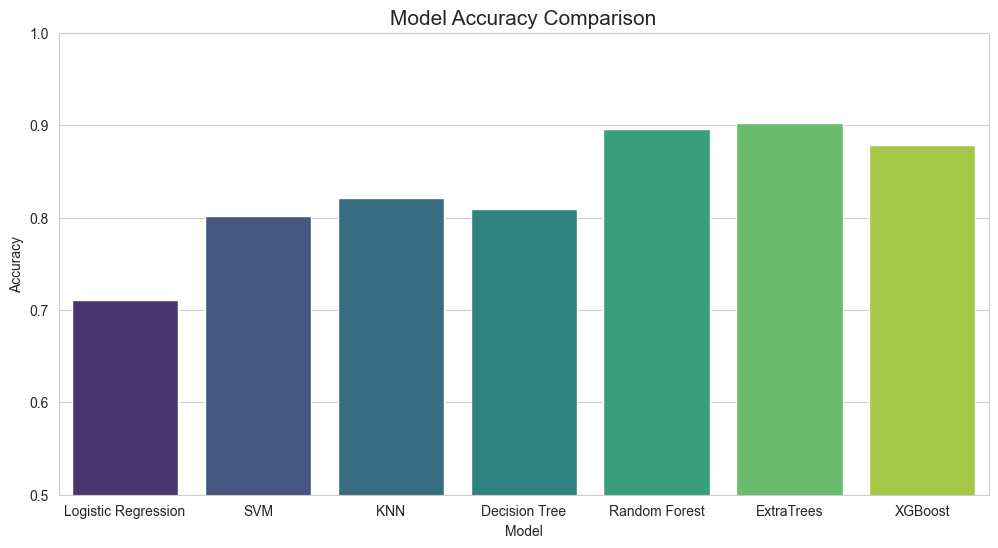

In [12]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=15)
plt.ylim(0.5, 1.0)
plt.show()

## 8. Selecting & Saving the Best Model

🏆 Best Model: ExtraTrees with Accuracy: 0.9024


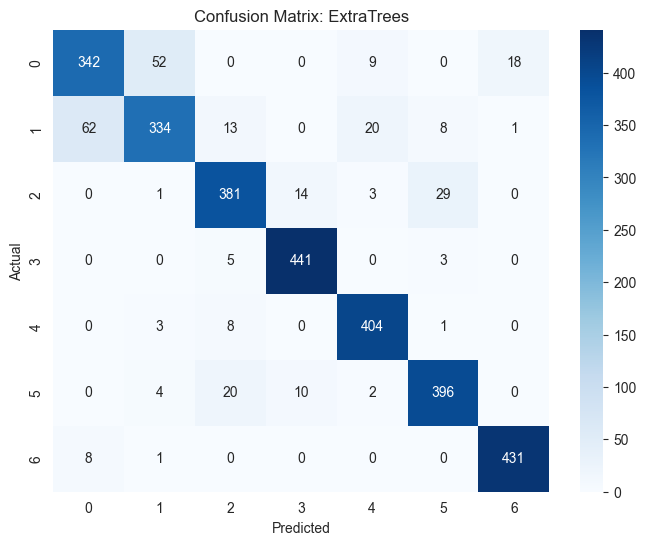

Saved ExtraTrees as 'best_forest_model.pkl'


In [13]:
# Find best model
best_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_model_name = best_row['Model']
print(f"🏆 Best Model: {best_model_name} with Accuracy: {best_row['Accuracy']:.4f}")

# Retrieve the object based on name
model_map = {
    "Logistic Regression": lr_model,
    "SVM": svm_model,
    "KNN": knn_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "ExtraTrees": et_model,
    "XGBoost": xgb_model
}
best_model_obj = model_map[best_model_name]

# Confusion Matrix for Best Model
preds = best_model_obj.predict(X_valid)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_valid, preds), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save
joblib.dump(best_model_obj, 'best_forest_model.pkl')
print(f"Saved {best_model_name} as 'best_forest_model.pkl'")

## 9. Final Prediction Function
A production-ready function to handle raw input.

In [14]:
def predict_forest_cover(input_data_dict):
    loaded_model = joblib.load('best_forest_model.pkl')
    loaded_scaler = joblib.load('best_scaler.pkl')
    
    input_df = pd.DataFrame([input_data_dict])
    
    # Feature Engineering
    input_df['Total_Distance_To_Hydrology'] = (input_df['Vertical_Distance_To_Hydrology']**2 + input_df['Horizontal_Distance_To_Hydrology']**2)**0.5
    input_df['Elevation_Plus_Vertical_Hydrology'] = input_df['Elevation'] + input_df['Vertical_Distance_To_Hydrology']
    input_df['Elevation_Minus_Vertical_Hydrology'] = input_df['Elevation'] - input_df['Vertical_Distance_To_Hydrology']
    input_df['Hydrology_Plus_Fire_Points'] = input_df['Horizontal_Distance_To_Hydrology'] + input_df['Horizontal_Distance_To_Fire_Points']
    input_df['Hydrology_Minus_Fire_Points'] = input_df['Horizontal_Distance_To_Hydrology'] - input_df['Horizontal_Distance_To_Fire_Points']
    input_df['Hydrology_Plus_Roadways'] = input_df['Horizontal_Distance_To_Hydrology'] + input_df['Horizontal_Distance_To_Roadways']
    input_df['Hydrology_Minus_Roadways'] = input_df['Horizontal_Distance_To_Hydrology'] - input_df['Horizontal_Distance_To_Roadways']
    input_df['Fire_Points_Plus_Roadways'] = input_df['Horizontal_Distance_To_Fire_Points'] + input_df['Horizontal_Distance_To_Roadways']
    input_df['Fire_Points_Minus_Roadways'] = input_df['Horizontal_Distance_To_Fire_Points'] - input_df['Horizontal_Distance_To_Roadways']
    
    # Scale
    cols = [c for c in input_df.columns if not c.startswith('Wilderness') and not c.startswith('Soil')]
    input_df[cols] = loaded_scaler.transform(input_df[cols])
    
    # Predict
    return loaded_model.predict(input_df)[0] + 1

# Test on a sample row
sample = df.drop('Cover_Type', axis=1).iloc[0].to_dict()
print(f"Predicted Class for Sample: {predict_forest_cover(sample)}")

Predicted Class for Sample: 5
